In [ ]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    """Function to Download Data"""
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [ ]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head()

In [ ]:
housing.describe() # method shows a summary of the numerical attributes 

In [ ]:
%matplotlib inline  
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Get a test data set

In [ ]:
import numpy as np
from zlib import crc32

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]



def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

print(len(train_set), len(test_set))
# This are not representative because they are too random

In [ ]:
from sklearn.model_selection import train_test_split
# Using scikit learn functions to get data tes

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
# these are not representative

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Using this to get stratified data test taking income_cat as reference

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print(strat_train_set)
print(strat_test_set)

In [ ]:
# Copy training set to not alter the original
housing = strat_train_set.copy()

## Visualizing Data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

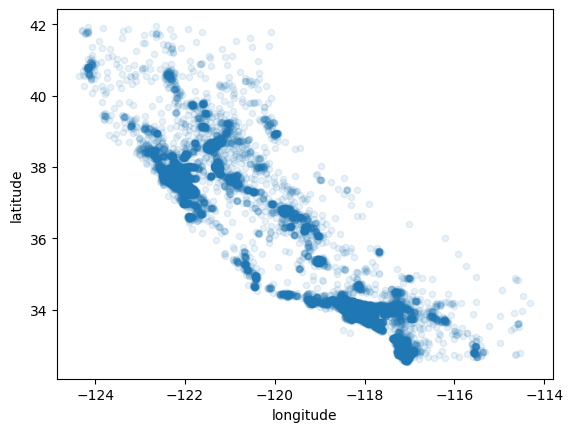

In [12]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

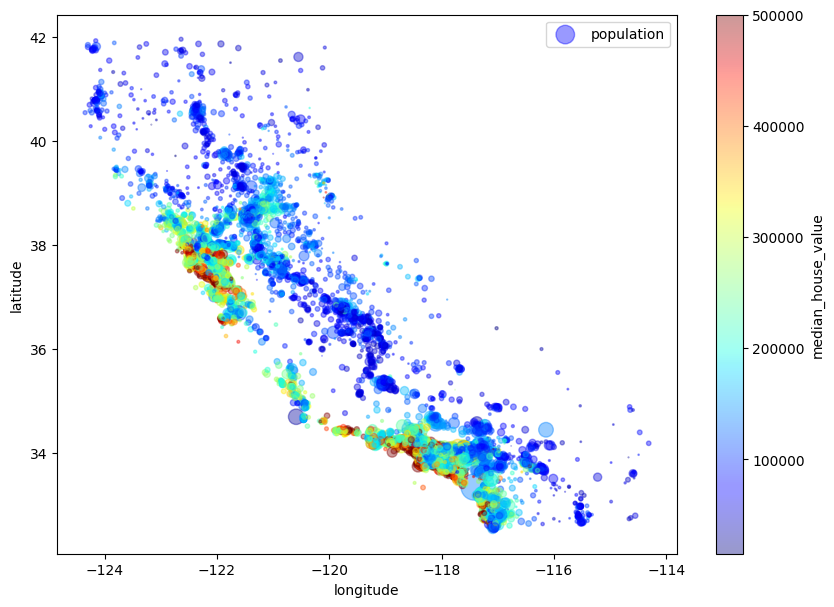

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

## Correlations

In [22]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'] # Only for linear correlation

longitude            -0.047466
latitude             -0.142673
housing_median_age    0.114146
total_rooms           0.135140
total_bedrooms        0.047781
population           -0.026882
households            0.064590
median_income         0.687151
median_house_value    1.000000
Name: median_house_value, dtype: float64